In [1]:
import os
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore")

In [2]:
import torch

if torch.cuda.is_available():
    print("GPU is available!")
    print(f"Using device: {torch.cuda.get_device_name(0)}")
else:
    print("No GPU. Using CPU.")

GPU is available!
Using device: Tesla T4


In [3]:
!pip install gdown --quiet
!gdown '1bzTrvDtnVOeL9Ft_6omSKumvU8qaO3vw'

Downloading...
From (original): https://drive.google.com/uc?id=1bzTrvDtnVOeL9Ft_6omSKumvU8qaO3vw
From (redirected): https://drive.google.com/uc?id=1bzTrvDtnVOeL9Ft_6omSKumvU8qaO3vw&confirm=t&uuid=33c5a065-156d-460a-9e6e-c6d588bcc3ab
To: /content/final_data_with_summarization.csv
100% 288M/288M [00:05<00:00, 51.1MB/s]


# 1. Loading the Data

In [4]:
df = pd.read_csv(r"final_data_with_summarization.csv")

In [5]:
df["input"] = df["text_summary"].fillna(df["text"])

In [6]:
df["input"].isnull().sum()

np.int64(39)

In [7]:
X = df["title"].fillna("") + " " + df["input"].fillna("")

In [8]:
Y = df["label"]

In [9]:
X.values[10]

'U.N. seeks humanitarian pause in Sanaa where streets "battlegrounds" GENEVA (Reuters) - The United Nations called on Monday for a humanitarian pause in the Yemeni capital of Sanaa on Tuesday to allow civilians to leave their homes, aid workers to reach them, and the wounded to get medical care. Jamie McGoldrick, U.N. humanitarian coordinator in Yemen, said in a statement that the streets of Sanaa had become  battlegrounds  and that aid workers  remain in lockdown .  Thus, I call on all parties to the conflict to urgently enable a humanitarian pause on Tuesday 5 December, between 10:00 a.m. and 16:00 p.m. to allow civilians to leave their homes and seek assistance and protection and to facilitate the movement of aid workers to ensure the continuity of life-saving programs,  he said.  McGoldrick warned the warring parties that any deliberate attacks against civilians, and against civilian and medical infrastructure, are  clear violations of international humanitarian law and may constit

In [10]:
Y[10]

np.int64(0)

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=42)

In [12]:
X_train.shape, X_val.shape, X_test.shape

((49043,), (8655,), (14425,))

In [13]:
X_train = X_train.values
X_val = X_val.values
X_test = X_test.values

y_train = y_train.values
y_val = y_val.values
y_test = y_test.values

<b> 0 = Real, 1 = Fake

# 2. Preparing Data Loaders and Model

We use the [sentence-transformers/all-MiniLM-L6-v2](https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2) embedding model from huggingface and fine tune it.

In [14]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import AutoModel, AutoTokenizer
from sklearn.metrics import accuracy_score
from tqdm import tqdm

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels.astype("float32")

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]

In [16]:
train_dataset = TextDataset(X_train, y_train)
val_dataset = TextDataset(X_val, y_val)
test_dataset = TextDataset(X_test, y_test)

In [17]:
batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [18]:
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer, AutoModel

In [19]:
class EmbeddingClassifier(nn.Module):
    def __init__(self, model_name='sentence-transformers/all-MiniLM-L6-v2'):
        super(EmbeddingClassifier, self).__init__()
        self.encoder = AutoModel.from_pretrained(model_name)
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)

        self.classifier = nn.Sequential(
            nn.Linear(384, 128),
            nn.LeakyReLU(),
            nn.Linear(128, 128),
            nn.LeakyReLU(),
            nn.Linear(128, 2)
        )

    def mean_pooling(self, model_output, attention_mask):
        token_embeddings = model_output.last_hidden_state
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size())
        return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(
            input_mask_expanded.sum(1), min=1e-9
        )

    def forward(self, input_texts):
        encoded = self.tokenizer(
            input_texts,
            padding=True,
            truncation=True,
            return_tensors='pt'
        ).to(next(self.parameters()).device)

        model_output = self.encoder(**encoded)
        sentence_embeddings = self.mean_pooling(model_output, encoded['attention_mask'])
        logits = self.classifier(sentence_embeddings)
        return logits  # ouput shape: [batchsize, 2]

In [20]:
for features, labels in train_loader:
  break

In [21]:
NN_Model = EmbeddingClassifier()
NN_Model.to(device)

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

EmbeddingClassifier(
  (encoder): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 384, padding_idx=0)
      (position_embeddings): Embedding(512, 384)
      (token_type_embeddings): Embedding(2, 384)
      (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-5): 6 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
              (LayerNorm): LayerNorm((384,), eps=1e-12, elem

As we can see, we appended a multi-layered perceptron on top of the embedding model. Lets see if we get expected output in a forward pass for a batch of data.

In [22]:
outputs = NN_Model(features)

In [23]:
outputs.shape

torch.Size([64, 2])

In [24]:
all_on_gpu = all(p.device.type == 'cuda' for p in NN_Model.parameters())
print("All model parameters on GPU:", all_on_gpu)

All model parameters on GPU: True


In [25]:
total_params = sum(p.numel() for p in NN_Model.parameters() if p.requires_grad)
print(f"Total trainable parameters: {total_params}")

Total trainable parameters: 22779266


Perfect!!! Our forward pass works as expected. Now, lets create some helper functions and train our model.

# 3. Helper Functions

In [26]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

In [27]:
def perform_deep_test_analysis(y_test, test_preds: np.array, test_preds_proba: np.array, model_name: str) -> None:
    """"
    This function takes in a model object and model name, and performs a deep analysis on the model's performance on the test set.
    It prints classification report, confusion matrix, ROC AUC score and plots the ROC curve.
    """
    cm = confusion_matrix(y_test, test_preds)

    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    print("\n")
    print("FOR TESTING SET: ")
    print(classification_report(y_test, test_preds))
    print("\n")

    print(f"ROC AUC Score: {roc_auc_score(y_test, test_preds_proba):.2%}")
    print("\n")

    fpr, tpr, _ = roc_curve(y_test, test_preds_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic Curve for {model_name}')
    plt.legend(loc="lower right")
    plt.show()

# 4. Model Training

In [28]:
import torch.optim as optim

scaler = torch.cuda.amp.GradScaler()

In [29]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(NN_Model.parameters(), lr=0.0001, weight_decay=0.001)
num_epochs = 7
early_stopping_patience = 4

In [33]:
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []

best_val_loss = np.inf
best_val_acc_at_best_loss = 0.0
best_epoch = -1
epochs_no_improve = 0
best_model_wts = NN_Model.state_dict()

for epoch in range(num_epochs):
    NN_Model.train()
    running_loss = 0.0
    running_corrects = 0
    running_total = 0

    for xb, yb in tqdm(train_loader):
        yb = yb.to(device).long()  # Features already on GPU inside model class
        optimizer.zero_grad()

        with torch.cuda.amp.autocast():
            out = NN_Model(xb)
            loss = criterion(out, yb)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * len(xb)
        preds = out.argmax(dim=1)
        running_corrects += (preds == yb).sum().item()
        running_total += yb.size(0)

    epoch_train_loss = running_loss / running_total
    epoch_train_acc = running_corrects / running_total
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_acc)

    NN_Model.eval()
    val_running_loss = 0.0
    val_running_corrects = 0
    val_running_total = 0
    with torch.no_grad():
        for xb, yb in tqdm(val_loader):
            yb = yb.to(device).long()

            with torch.cuda.amp.autocast():
                out = NN_Model(xb)
                loss = criterion(out, yb)

            val_running_loss += loss.item() * len(xb)
            preds = out.argmax(dim=1)
            val_running_corrects += (preds == yb).sum().item()
            val_running_total += yb.size(0)

    epoch_val_loss = val_running_loss / val_running_total
    epoch_val_acc = val_running_corrects / val_running_total
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_acc)

    print(f"Epoch {epoch+1}: "
          f"Train Loss={epoch_train_loss:.4f}, Train Acc={epoch_train_acc:.4f}, "
          f"Val Loss={epoch_val_loss:.4f}, Val Acc={epoch_val_acc:.4f}")

    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        best_val_acc_at_best_loss = epoch_val_acc
        best_epoch = epoch + 1
        epochs_no_improve = 0
        best_model_wts = NN_Model.state_dict()
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= early_stopping_patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

print(f"\nBest model saved at epoch {best_epoch} with "
      f"Val Loss={best_val_loss:.4f} and Val Acc={best_val_acc_at_best_loss:.4f} "
      f"(Early Stopping Patience = {early_stopping_patience})")

100%|██████████| 136/136 [00:21<00:00,  6.45it/s]


Epoch 1: Train Loss=0.1762, Train Acc=0.9303, Val Loss=0.1109, Val Acc=0.9552


100%|██████████| 136/136 [00:20<00:00,  6.61it/s]


Epoch 2: Train Loss=0.0932, Train Acc=0.9666, Val Loss=0.0924, Val Acc=0.9661


100%|██████████| 136/136 [00:20<00:00,  6.51it/s]


Epoch 3: Train Loss=0.0751, Train Acc=0.9744, Val Loss=0.1177, Val Acc=0.9634


100%|██████████| 136/136 [00:21<00:00,  6.46it/s]


Epoch 4: Train Loss=0.0580, Train Acc=0.9809, Val Loss=0.1442, Val Acc=0.9494


100%|██████████| 136/136 [00:20<00:00,  6.66it/s]


Epoch 5: Train Loss=0.0465, Train Acc=0.9846, Val Loss=0.1223, Val Acc=0.9638


100%|██████████| 136/136 [00:20<00:00,  6.51it/s]

Epoch 6: Train Loss=0.0353, Train Acc=0.9878, Val Loss=0.1676, Val Acc=0.9581
Early stopping at epoch 6

Best model saved at epoch 2 with Val Loss=0.0924 and Val Acc=0.9661 (Early Stopping Patience = 4)


In [34]:
torch.save(best_model_wts, 'EmbeddingClassifier_FineTuned.pth')

In [35]:
NN_Model.load_state_dict(torch.load('EmbeddingClassifier_FineTuned.pth'))

<All keys matched successfully>

In [36]:
def make_predictions_using_NN(model, data_loader):
    model.eval()
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for xb, labels in tqdm(data_loader):
            logits = model(xb)
            probs = torch.softmax(logits, dim=1)
            preds = torch.argmax(logits, dim=1)
            all_preds.append(preds.cpu())
            all_probs.append(probs.cpu())

    all_preds = torch.cat(all_preds)
    all_probs = torch.cat(all_probs)
    return all_preds, all_probs

In [37]:
train_preds, train_probs_1dCNN = make_predictions_using_NN(NN_Model, train_loader)
val_preds, val_probs_1dCNN = make_predictions_using_NN(NN_Model, val_loader)
test_preds, test_probs_1dCNN = make_predictions_using_NN(NN_Model, test_loader)

100%|██████████| 226/226 [01:21<00:00,  2.78it/s]


In [38]:
print("Training performance")
print(classification_report(y_train, train_preds))

Training performance
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     23853
           1       1.00      0.99      0.99     25190

    accuracy                           0.99     49043
   macro avg       0.99      0.99      0.99     49043
weighted avg       0.99      0.99      0.99     49043



In [39]:
print("Val performance")
print(classification_report(y_val, val_preds))

Val performance
              precision    recall  f1-score   support

           0       0.94      0.97      0.96      4097
           1       0.97      0.95      0.96      4558

    accuracy                           0.96      8655
   macro avg       0.96      0.96      0.96      8655
weighted avg       0.96      0.96      0.96      8655



In [40]:
print("Test performance")
print(classification_report(y_test, test_preds))

Test performance
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      7078
           1       0.97      0.95      0.96      7347

    accuracy                           0.96     14425
   macro avg       0.96      0.96      0.96     14425
weighted avg       0.96      0.96      0.96     14425



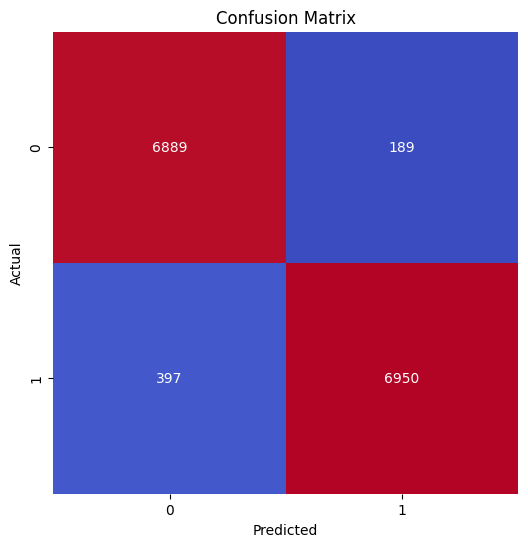



FOR TESTING SET: 
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      7078
           1       0.97      0.95      0.96      7347

    accuracy                           0.96     14425
   macro avg       0.96      0.96      0.96     14425
weighted avg       0.96      0.96      0.96     14425



ROC AUC Score: 99.34%




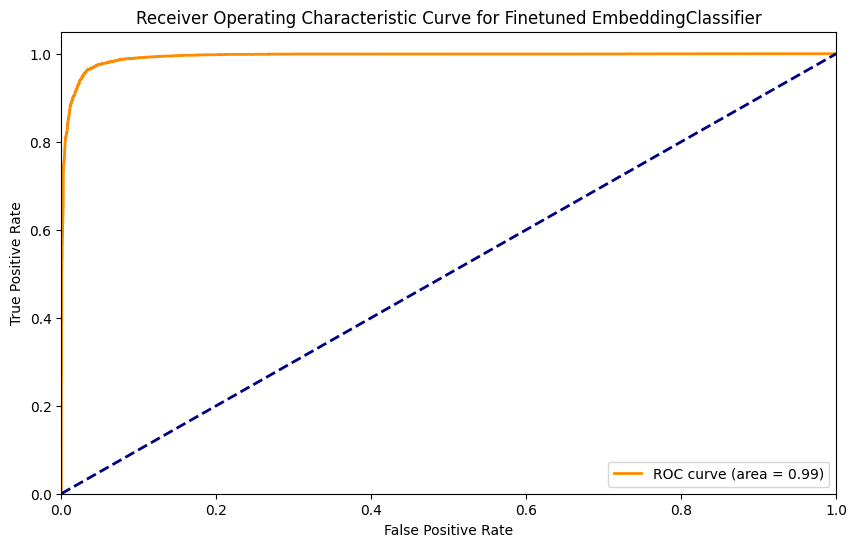

In [41]:
perform_deep_test_analysis(y_test, test_preds, test_probs_1dCNN[:, 1], "Finetuned EmbeddingClassifier")